100%|██████████| 500/500 [00:26<00:00, 18.74it/s]


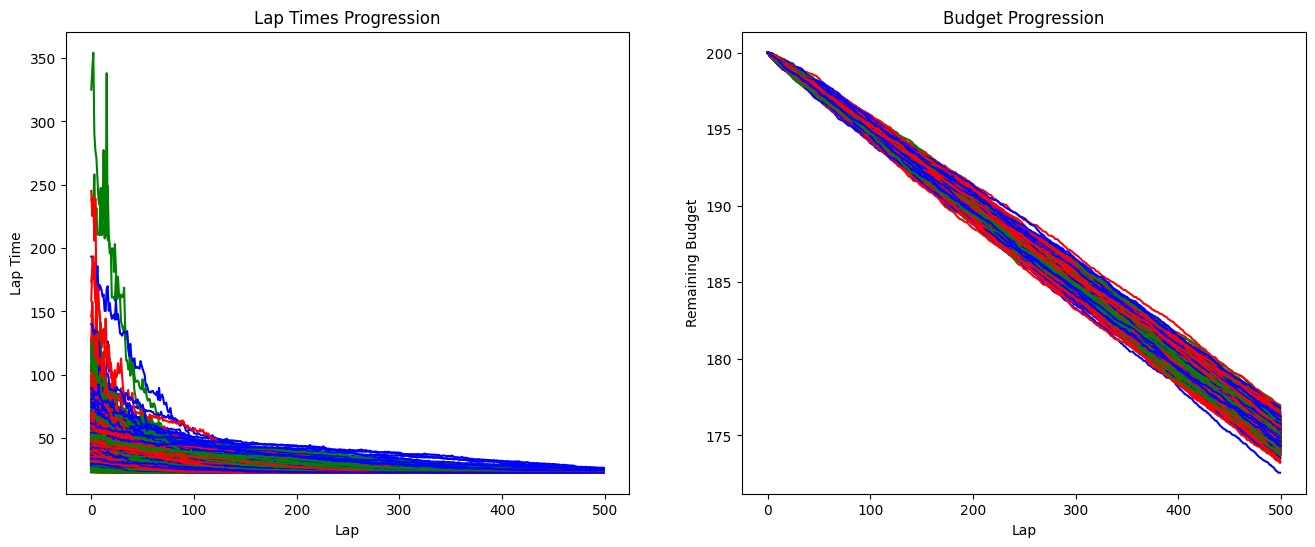

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tqdm import tqdm

# LOG_INTERVAL = 1

def generate_fourier_vectorized(L, n, N=10, kappa=0.25):
    x = np.linspace(0, 1, L)
    highest_frequency = int(N * kappa)
    frequencies = np.arange(1, highest_frequency+1)
    A = np.random.randn(n, highest_frequency)
    B = np.random.randn(n, highest_frequency)
    track = np.sum(A[:,:,None] * np.cos(2 * np.pi * frequencies[None, :, None] * x[None,None,:]) +
                   B[:,:,None] * np.sin(2 * np.pi * frequencies[None, :, None] * x[None,None,:]), axis=1)
    track += np.random.randn(n, 1)
    return track.T


def generate_shape(x, a_coeff, b_coeff, f=1.0):
    """
    Generate a shape based on Fourier series.
    
    Parameters:
    - x: array-like, the coordinate along the shape
    - a_coeff: array-like, the a_n coefficients for the Fourier series
    - b_coeff: array-like, the b_n coefficients for the Fourier series
    - f: float, the fundamental frequency
    
    Returns:
    - y: array-like, the y-coordinates of the shape
    """
    if len(a_coeff) != len(b_coeff):
        raise ValueError("Length of a_coeff and b_coeff must be the same.")
    
    N = len(a_coeff)
    y = np.zeros_like(x)
    
    for n in range(1, N+1):
        y += a_coeff[n-1] * np.cos(2 * np.pi * n * f * x) + b_coeff[n-1] * np.sin(2 * np.pi * n * f * x)
        
    return y


def speed_vectorized(agent, track_features, alpha=1.0, beta=1.0):
    dot_product = np.einsum('ij,ij->i', agent, track_features)
    norm_agent = np.linalg.norm(agent, axis=1)
    norm_track = np.linalg.norm(track_features, axis=1)
    return alpha + beta * dot_product / (norm_agent * norm_track)

def rotate_features(agent, theta, u, v):
    """Rotates agent's features in the plane defined by vectors u and v."""
    I = np.identity(len(agent))
    rotation_matrix = (I + (np.cos(theta) - 1) * (np.outer(u, u) + np.outer(v, v)) +
                    np.sin(theta) * (np.outer(u, v) - np.outer(v, u)))
    return np.dot(rotation_matrix, agent)


# # # Deprecated
# def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
#                 budget, agent_idx, min_improvement=0.05, rotation_scale=0.1):
#     if budget > 0:
#         # Initialize if not provided
#         if last_best_lap_time[agent_idx] is None:
#             last_best_lap_time[agent_idx] = float('inf')

#         if lap_time <= last_best_lap_time[agent_idx]:
#             # Update best-known state and lap time
#             last_best_agent_state[agent_idx] = np.copy(agent)
#             last_best_lap_time[agent_idx] = lap_time

#             # Generate random rotation angle and basis vectors
#             theta = np.random.uniform(-rotation_scale, rotation_scale)
#             u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
#             u /= np.linalg.norm(u)
#             v /= np.linalg.norm(v)

#             # Rotate features
#             agent = rotate_features(agent, theta, u, v)
#             budget -= np.abs(theta)
#         else:
#             # Roll back to the best-known state if no improvement
#             agent = np.copy(last_best_agent_state[agent_idx])

#     return agent, budget

def optimize_agent(agent, lap_time, last_best_lap_time, last_best_agent_state,
                budget, agent_idx, min_improvement=0.05, rotation_scale=0.1, method = 'random'):
    
    if budget > 0:
        # Initialize if not provided
        if last_best_lap_time[agent_idx] is None:
            last_best_lap_time[agent_idx] = float('inf')

        if lap_time <= last_best_lap_time[agent_idx]:
            # Update best-known state and lap time
            last_best_agent_state[agent_idx] = np.copy(agent)
            last_best_lap_time[agent_idx] = lap_time
        else:
            # Set to the best-known state if the current lap time is worse
            agent = np.copy(last_best_agent_state[agent_idx])

        # Generate random rotation angle and basis vectors
        theta = np.random.uniform(-rotation_scale, rotation_scale)

        if method == 'random':
            u, v = np.random.randn(len(agent)), np.random.randn(len(agent))
            u /= np.linalg.norm(u)
            v /= np.linalg.norm(v)

        elif method == 'orthogonal':
            u, v = generate_orthogonal_u_v(agent)
        
        elif method == 'max_feature':
            u, v = generate_u_v_from_max_feature(agent)
        
        
        

        # Rotate features
        agent = rotate_features(agent, theta, u, v)
        budget -= np.abs(theta)

    return agent, budget

def generate_orthogonal_u_v(agent):
    """Generates two orthogonal vectors in the plane of the agent's features."""
    u = np.random.randn(len(agent))
    u /= np.linalg.norm(u)
    v = np.random.randn(len(agent))
    v -= np.dot(v, u) * u
    v /= np.linalg.norm(v)
    return u, v

def generate_u_v_from_max_feature(agent):
    """Generates two vectors in the plane of the agent's features, one pointing to the direction of the maximum absolute feature and the other orthogonal to it."""
    max_feature_idx = np.argmax(np.abs(agent))
    u = np.zeros(len(agent))
    u[max_feature_idx] = 1
    v = np.random.randn(len(agent))
    v -= np.dot(v, u) * u
    v /= np.linalg.norm(v)
    return u, v
 

def main(num_agents=3, num_laps=10, initial_budget=1.0, live_plotting=True, pretrained_agents=None, track=None, dt = 0.5):
    L, n, alpha, beta = 30, 5, 1.0, 1.0
    colors = ['b', 'g', 'r']  # Add more colors if needed
    methods = ['random', 'orthogonal', 'max_feature']
    
    if track is None:
        track = generate_fourier_vectorized(L, n)
    else:
        track = np.array(track)
    if pretrained_agents is not None:
        num_agents = len(pretrained_agents)
        agents = np.array([np.array(agent) for agent in pretrained_agents])
    else:
        agents = np.array([np.random.randn(n) for _ in range(num_agents)])
    budgets = np.full(num_agents, initial_budget)
    
    lap_times_history = np.zeros((num_laps, num_agents))
    budget_history = np.zeros((num_laps, num_agents))
    
    last_best_agent_state = agents.copy()
    last_best_lap_time = np.full(num_agents, np.inf)
    
    if live_plotting:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
        
        # Plot features
        for i in range(n):
            # title subplot
            ax1.set_title('Track Features')
            ax1.plot(np.linspace(0, L, L), track[:, i], label=f'Feature {i+1}')
        ax1.legend()
        
        points = [ax1.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
        circles = [ax2.plot([], [], 'o', lw=3, color=colors[i % len(colors)])[0] for i in range(num_agents)]
        ax2.set_title('Agent Positions')
        ax2.plot(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)), 'k--')
        # as above but using generate_
    
    for lap in tqdm(range(num_laps)):
        positions = np.zeros(num_agents)
        lap_times = np.zeros(num_agents)
        
        while np.any(positions < L):
            s = np.floor(positions).astype(int) % L
            v = speed_vectorized(agents, track[s])
            positions += v * dt
            
            # Update lap_times only for agents still running
            mask = positions < L
            lap_times[mask] += dt
            
            if live_plotting:
                for i in range(num_agents):
                    points[i].set_data(positions[i] % L, 0)
                    theta = 2 * np.pi * (positions[i] % L) / L
                    circles[i].set_data(np.cos(theta), np.sin(theta))

                clear_output(wait=True)
                display(fig)
                plt.pause(0.01)
                
        lap_times_history[lap, :] = lap_times
        budget_history[lap, :] = budgets
        
        for i in range(num_agents):
            agents[i], budgets[i] = optimize_agent(
                agents[i], lap_times[i], last_best_lap_time,
                last_best_agent_state, budgets[i], i, method = methods[i % len(methods)])
            
        
        if live_plotting:
            ax3.clear()
            ax4.clear()
            for i in range(num_agents):
                ax3.plot(range(lap + 1), lap_times_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
                ax4.plot(range(lap + 1), budget_history[:lap+1, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
            ax3.legend()
            ax4.legend()
            ax3.set_title('Lap Times Progression')
            ax4.set_title('Budget Progression')
            ax3.set_xlabel('Lap')
            ax4.set_xlabel('Lap')
            ax3.set_ylabel('Lap Time')
            ax4.set_ylabel('Remaining Budget')
    
    if not live_plotting:
        # Plot the lap times history and budget history only at the end
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        for i in range(num_agents):
            axs[0].plot(range(num_laps), lap_times_history[:, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
            axs[1].plot(range(num_laps), budget_history[:, i], label=f'Agent {i+1}', color=colors[i % len(colors)])
        # axs[0].legend()
        # axs[1].legend()
        axs[0].set_title('Lap Times Progression')
        axs[1].set_title('Budget Progression')
        axs[0].set_xlabel('Lap')
        axs[1].set_xlabel('Lap')
        axs[0].set_ylabel('Lap Time')
        axs[1].set_ylabel('Remaining Budget')
        plt.show()
    
    return lap_times_history, budget_history, agents, track


lap_times_history, budget_history, trained_agents, track = main(num_agents=1000, num_laps=500, initial_budget=200.0, live_plotting=False, dt=0.1)


In [2]:
main(num_agents=10, num_laps=50, initial_budget=100.0, live_plotting=True, pretrained_agents=trained_agents, track=track, dt=0.2)

 16%|█▌        | 8/50 [06:40<35:04, 50.10s/it]


KeyboardInterrupt: 

In [39]:
# To do:
    # Fix inefficiency in optimization loop:
        # FIXED - The agent should not be reverted to the best known state if there is no improvement, instead it should be rotated again from the best-known state -- FIXED
    # - Add agent interaction:
        # - A following agent should be slowed down by the agent in front of it to mimic real life